# Figures for defense talk

In [34]:
import pandas as pd
import scipy.stats as st
import numpy as np
import pymc3 as pm
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.25)
sns.set_style('whitegrid')

In [35]:
tumor = pd.read_hdf('/mnt/data/outlier/tumor.hd5')
gtex = pd.read_hdf('/mnt/data/outlier/gtex.hd5')
normal = pd.read_hdf('/mnt/data/outlier/normal.hd5')
out_dir = '/mnt/figures/outlier-story/'

## Outlier Story - what's the problem?

In the beginning... there was a sample

In [36]:
sample_id = 'TCGA-HT-7610-01'
sample = tumor.loc[sample_id]

We want to know what makes this particular tumor special, since we're doing this so we can figure out how to kill it, we'll do it the courtesy of not telling it. As an example, let's examine the sample's expression of **AURKB** compared with other normal samples

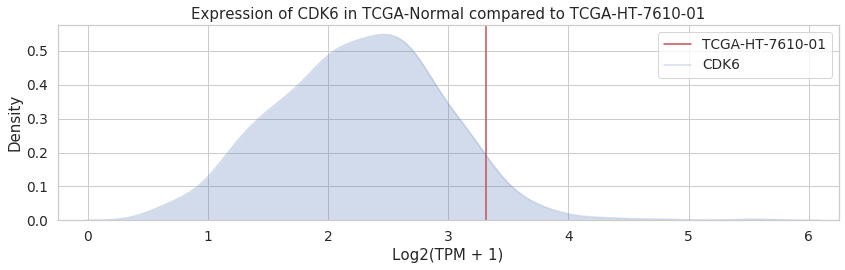

In [37]:
gene = 'CDK6'
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
sns.kdeplot(normal[gene], shade=True, alpha=0.25)
plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Expression of {gene} in TCGA-Normal compared to {sample_id}');
plt.xlim([-0.25, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '1-TCGA-Normal.png'), dpi=300, transparent=True)

Our sample looks like it might be a significant outlier, but does it make sense to compare our sample to all normals? Let's look at the sample's metadata and see if we can't find a more concise comparison.

In [38]:
sample.subtype

'Brain_Lower_Grade_Glioma'

so the sample is a **Lower grade glioma**

So let's look for a normal to compare it to in the same dataset — oh no, only **5**. That's not a lot of samples and maybe we should be worried that's not quite enough to be confident in the answer we'll get by performing such a comparison

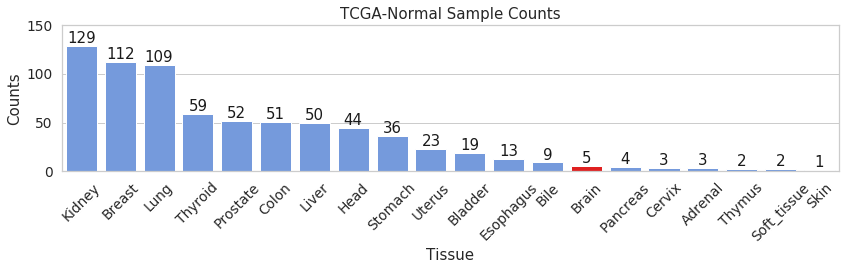

In [65]:
plt.figure(figsize=(12, 4))
tissue_order = normal.tissue.value_counts().index
clrs = ['cornflowerblue' if x != 'Brain' else 'red' for x in tissue_order]
sns.countplot(data=normal, x='tissue', order=tissue_order, palette=clrs)
plt.xticks(rotation=45)
plt.title('TCGA-Normal Sample Counts')
plt.ylim([0, 140])
plt.ylabel('Counts')
plt.xlabel('Tissue')
# Add counts
for i, v in normal.tissue.value_counts().reset_index().iterrows():
    plt.text(i, v.tissue + 3, v.tissue, color='k', ha='center')
plt.ylim([0, 150])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '2-TCGA-Normal-counts.png'), dpi=300, transparent=True)

Let's not despair, maybe there's some more normal data we can use for our comparison. Let's look at this other dataset GTEx, it has lots of normals. 

In [40]:
df = pd.concat([gtex, normal])

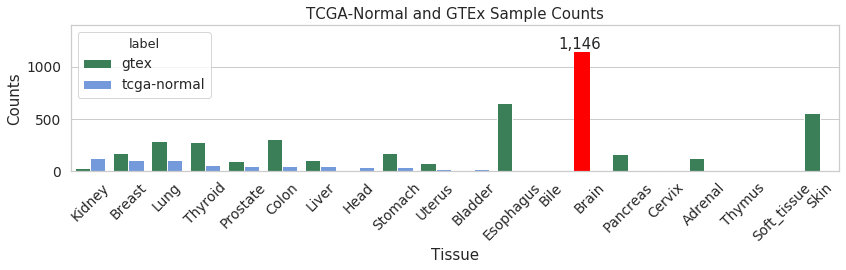

In [73]:
plt.figure(figsize=(12, 4))
order = normal.tissue.value_counts().index
ax = sns.countplot(data=df, x='tissue', hue='label', order=order, palette=['seagreen', 'cornflowerblue'])
plt.xticks(rotation=45)
plt.title('TCGA-Normal and GTEx Sample Counts')
plt.ylabel('Counts')
plt.xlabel('Tissue')
plt.ylim([0, 1300])
plt.text(12.75, 1175, '1,146', ha='center')
# Color
for i, bar in enumerate(ax.patches):
    if i == 13:
        bar.set_color('red')
plt.ylim([0, 1400])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '3-GTEx-counts.png'), dpi=300, transparent=True)

Holy smokes, that's a lot of Brain normals! I guess it's easier to collect normal brain tissue when the donors are dead. Ok, let's look at our sample compared to all GTEx samples and make sure it at least looks similar to TCGA-normal.

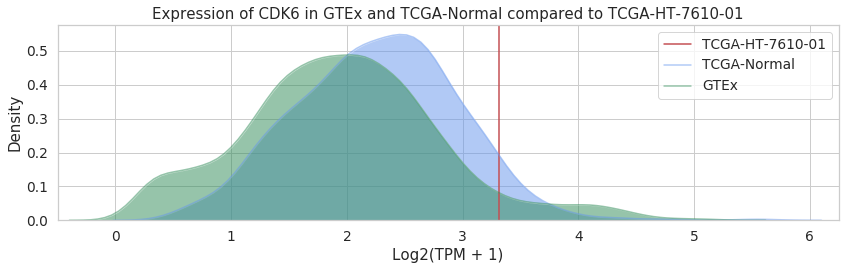

In [42]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
sns.kdeplot(normal[gene], shade=True, alpha=0.50, label='TCGA-Normal', color='cornflowerblue')
sns.kdeplot(gtex[gene], shade=True, alpha=0.50, label='GTEx', color='seagreen')
plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Expression of {gene} in GTEx and TCGA-Normal compared to {sample_id}');
plt.xlim([-0.5, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '4-GTEx-expression.png'), dpi=300, transparent=True)

Not a nice Gaussian distribution like TCGA-normal, but reasonably similar. Now let's overlay just the brain samples from GTEx

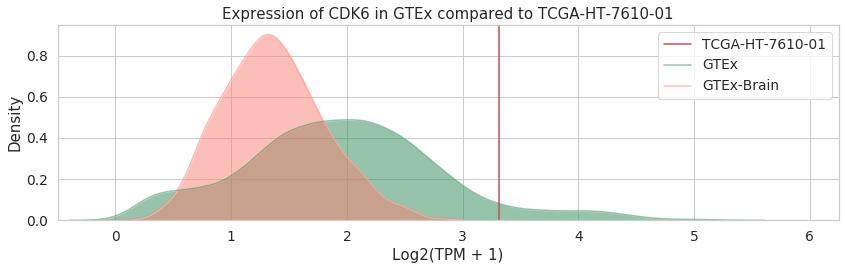

In [43]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
sns.kdeplot(gtex[gene], shade=True, alpha=0.50, label='GTEx', color='seagreen')
sns.kdeplot(gtex[gtex.tissue == 'Brain'][gene], shade=True, alpha=0.50, label='GTEx-Brain', color='salmon')
plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Expression of {gene} in GTEx compared to {sample_id}');
plt.xlim([-0.5, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '5-GTEx-Brain.png'), dpi=300, transparent=True)

Ok, now compared to GTEx Brain samples, our N-of-1 sample definitely seems like an outlier, but GTEx and TCGA were generated by different labs, and GTEx is collected from posthumous tissue, so maybe we're not sure how well what we *think* is the matched tissue will match to our N-of-1 sample. Also maybe our tumor is of unknown origin, a metastatic sample, was mislabelled, or displays a phenotype of non-specific lineage

INTRODUCE MODEL / existing options

### IQR Method

In [44]:
def iqr_bounds(ys, whis=1.5):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * whis)
    upper_bound = quartile_3 + (iqr * whis)
    return lower_bound, upper_bound

#### Pan-Normal

In [45]:
lower, upper = iqr_bounds(gtex[gene])

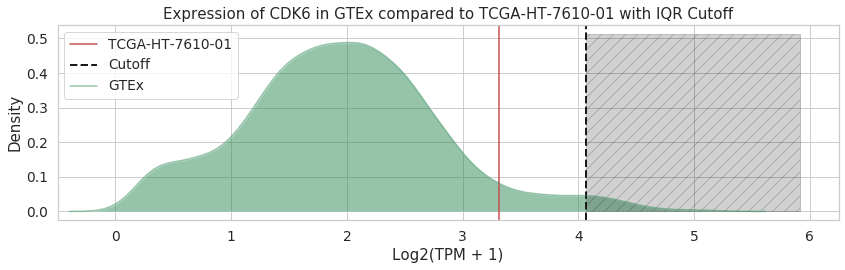

In [46]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
plt.axvline(upper, c='k', label='Cutoff', lw=2, ls='--')
sns.kdeplot(gtex[gene], shade=True, alpha=0.50, label='GTEx', color='seagreen')

# Fill
_, xmax = plt.gca().get_xlim()
_, ymax = plt.gca().get_ylim()
x = np.linspace(upper, xmax)
y = np.linspace(ymax, ymax)
plt.fill_between(x, y, color='k', alpha=0.20, hatch='//')

plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Expression of {gene} in GTEx compared to {sample_id} with IQR Cutoff');
plt.legend(loc='upper left')
plt.xlim([-0.5, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '6-GTEx-cutoff.png'), dpi=300, transparent=True)

#### Brain

In [47]:
lower, upper = iqr_bounds(gtex[gtex.tissue == 'Brain'][gene])

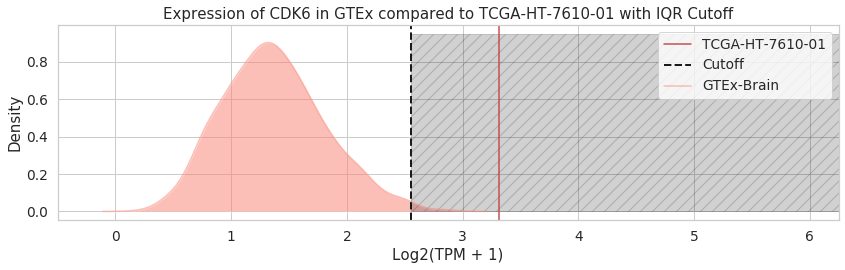

In [64]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
plt.axvline(upper, c='k', label='Cutoff', lw=2, ls='--')
sns.kdeplot(gtex[gtex.tissue == 'Brain'][gene], shade=True, alpha=0.50, label='GTEx-Brain', color='salmon')

plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Expression of {gene} in GTEx compared to {sample_id} with IQR Cutoff');
plt.xlim([-0.5, 6.25])

# Fill
_, xmax = plt.gca().get_xlim()
_, ymax = plt.gca().get_ylim()
x = np.linspace(upper, xmax)
y = np.linspace(ymax, ymax)
plt.fill_between(x, y, color='k', alpha=0.2, hatch='//')

plt.tight_layout()
plt.savefig(os.path.join(out_dir, '7-Brain-cutoff.png'), dpi=300, transparent=True)

### Trace

In [49]:
model_path = f'/mnt/normsd-outlier-runs/gtex-1000/{sample_id}/model.pkl'
with open(model_path, 'rb') as buff:
    data = pickle.load(buff)
trace = data['trace']

<Figure size 864x288 with 0 Axes>

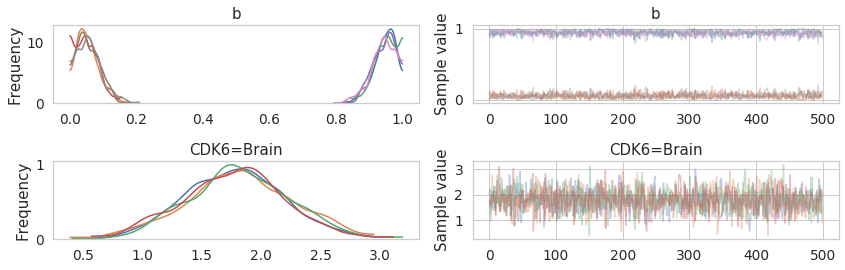

In [50]:
plt.figure(figsize=(12, 4))
pm.traceplot(trace, varnames=['b', f'{gene}=Brain'])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '8-trace.png'), dpi=300, transparent=True)

### Weights

In [51]:
from gene_outlier_detection.lib import calculate_weights

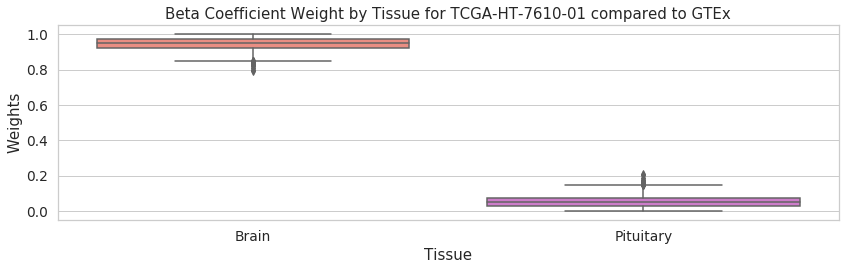

In [52]:
tissues = ['Brain', 'Pituitary']
weights = calculate_weights(tissues, trace)

plt.figure(figsize=(12, 4))
sns.boxplot(data=weights, x="Class", y="Weights", palette=['salmon', 'orchid'])
plt.xticks()

plt.xlabel('Tissue')
plt.ylabel('Weights')
plt.title(f'Beta Coefficient Weight by Tissue for {sample_id} compared to GTEx')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '9-Weights.png'), dpi=300, transparent=True)

### Trace Distribution for X

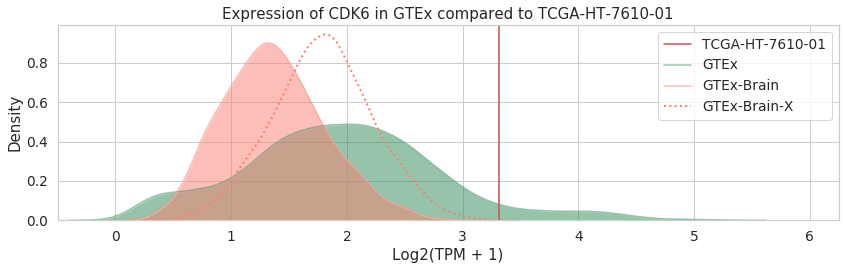

In [53]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
sns.kdeplot(gtex[gene], shade=True, alpha=0.50, label='GTEx', color='seagreen')
sns.kdeplot(gtex[gtex.tissue == 'Brain'][gene], color='salmon', shade=True, alpha=0.50, label='GTEx-Brain')
sns.kdeplot(trace[f'{gene}=Brain'], color='salmon', ls=':', lw=2, label='GTEx-Brain-X')
plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Expression of {gene} in GTEx compared to {sample_id}');
plt.xlim([-0.5, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '10-trace-x.png'), dpi=300, transparent=True)

### Posterior Predictive

In [54]:
from gene_outlier_detection.lib import posterior_predictive_check
from gene_outlier_detection.lib import posterior_predictive_pvals
from gene_outlier_detection.lib import t_fits

In [55]:
gene_path = '/mnt/data/outlier/drug-genes.txt'
drug_genes = [x.strip() for x in open(gene_path, 'r').readlines()]

In [56]:
training_df = gtex[gtex.tissue.isin(tissues)]

In [57]:
fits = t_fits(training_df, drug_genes, tissues, 'tissue')

In [58]:
ppc = posterior_predictive_check(trace, fits, drug_genes)
ppp = posterior_predictive_pvals(sample, ppc)

In [59]:
z = st.laplace.rvs(*st.laplace.fit(ppc[gene]), size=100_000)

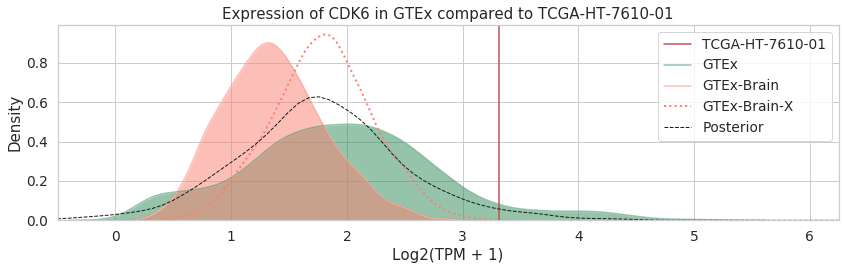

In [76]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
sns.kdeplot(gtex[gene], shade=True, alpha=0.50, label='GTEx', color='seagreen')
sns.kdeplot(gtex[gtex.tissue == 'Brain'][gene], color='salmon', shade=True, alpha=0.50, label='GTEx-Brain')
sns.kdeplot(trace[f'{gene}=Brain'], color='salmon', ls=':', lw=2, label='GTEx-Brain-X')
sns.kdeplot(ppc[gene], color='k', ls='--', lw=1, label='Posterior')
plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Expression of {gene} in GTEx compared to {sample_id}');
plt.xlim([-0.5, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '11-all.png'), dpi=300, transparent=True)

### Calculate P-value

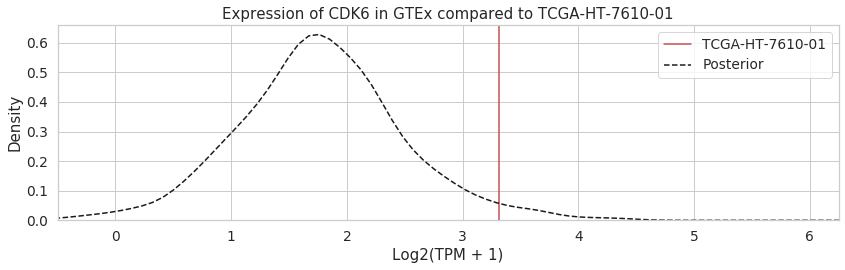

In [61]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
sns.kdeplot(ppc[gene], color='k', ls='--', lw=1.5, label='Posterior')
plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Expression of {gene} in GTEx compared to {sample_id}');
plt.xlim([-0.5, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '12-posterior.png'), dpi=300, transparent=True)

#### Denominator

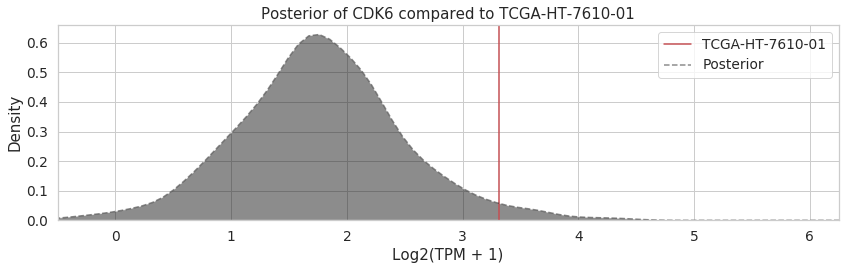

In [74]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
sns.kdeplot(ppc[gene], color='k', ls='--', lw=1.5, label='Posterior', shade=True, alpha=0.5)
plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Posterior of {gene} compared to {sample_id}');
plt.xlim([-0.5, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '13-denom.png'), dpi=300, transparent=True)

#### Numerator

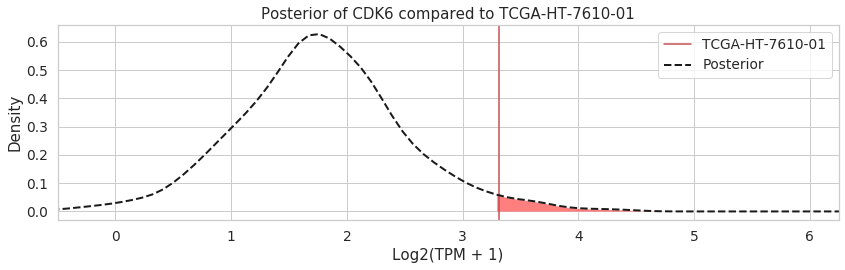

In [75]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label=sample_id)
#sns.kdeplot(gtex[gene], shade=True, alpha=0.25, label='GTEx')
#sns.kdeplot(gtex[gtex.tissue == 'Brain'][gene], shade=True, alpha=0.25, label='GTEx-Brain')
#sns.kdeplot(trace[f'{gene}=Brain'], color='orange', ls=':', lw=2, label='X')
ax = sns.kdeplot(ppc[gene], color='k', ls='--', lw=2, label='Posterior')

line = ax.get_lines()[-1]
x, y = line.get_data()
mask = x > sample[gene] - 0.1
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor='red')

plt.ylabel('Density')
plt.xlabel('Log2(TPM + 1)')
plt.title(f'Posterior of {gene} compared to {sample_id}');
plt.xlim([-0.5, 6.25])
plt.tight_layout()
plt.savefig(os.path.join(out_dir, '14-numerator.png'), dpi=300, transparent=True)